In [54]:
import numpy as np
import pandas as pd
import gurobipy as gp

In [55]:
#timelimit for running strategy 2
timelimit=3600

# Load and Prepare Data

In [56]:
stk_19=pd.read_csv('D:\\05_GitHub\\Data_Science_Projects\\Optimization\\Project2\\stocks2019.csv',index_col=0)
stk_20=pd.read_csv('D:\\05_GitHub\\Data_Science_Projects\\Optimization\\Project2\\stocks2020.csv',index_col=0)

# Daily return and Correlation Matrix

In [57]:
rt19=np.array(stk_19.pct_change().drop(columns='NDX',index='2019-01-02'))
rt20=np.array(stk_20.pct_change().drop(columns='NDX',index='1/2/20'))

cor19=np.array(stk_19.pct_change().drop(columns='NDX',index='2019-01-02').corr())
ticker=stk_19.columns[1:]

In [58]:
idx_rt19=np.array(stk_19['NDX'].pct_change().drop(index='2019-01-02'))
idx_rt20=np.array(stk_20['NDX'].pct_change().drop(index='1/2/20'))

# (1) Start with 5 stocks

In [59]:
m=5
n=cor19.shape[1]

In [60]:
A=np.zeros((n**2+n+1,n**2+n))
sense=np.array(['']*A.shape[0])
b=np.zeros((A.shape[0])) 

Constraint part I: $\sum \limits _{j=0} ^{100} X_{ij} $ =1   ..........100 constraints

In [61]:
# Constraint: 
row=0
for i in range(n):
    A[i,i*n:i*n+n]=1
    sense[i]='='
    b[i]=1

Constraint part II: $X_{ij}<Y_{j} $    ...........100*100 constraints

In [62]:
for i in range(n):
    for j in range(n):
        A[i * n + j + n, i * n + j]=1
        A[i * n + j + n, j + n**2]=-1
        sense[i * n + j + n]='<'
        b[i * n + j + n]=0

Constraint part III: $\sum \limits _{j=0} ^{n=100}y_{j}<m $    ...........1 constraints

In [63]:
#Weight cannot be larger than 0 if it's not selected
for j in range(n):
    A[n**2 + n, n**2 + j ] = 1
sense[n**2 + n] = '='
b[n**2 + n] = m

# Objective Function

In [64]:
obj=np.hstack((np.ndarray.flatten(cor19),np.array([0]*n)))

# Variable type

In [65]:
var_type=['B']*(n**2+n)

# Model

In [66]:
StkMod = gp.Model()
StkMod_x = StkMod.addMVar(len(obj),vtype=var_type) # vtype can be: 'C' or 'I' or 'B'
StkMod_con = StkMod.addMConstrs(A, StkMod_x, sense, b)
StkMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)

StkMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
StkMod.optimize()

In [67]:
# Max coefficient
StkMod.objVal

54.83990652229107

In [68]:
import math
port_idx=[]
for i in range(n**2,len(obj),1):
    if StkMod_x.x[i]==1:
        port_idx.append(i-n**2)

In [69]:
port_idx

[56, 59, 63, 94, 98]

# Tickers to choose

In [70]:
[ticker[i] for i in port_idx]

['LBTYK', 'MXIM', 'MSFT', 'VRTX', 'XEL']

# (2) Optimize weight matrix for 5 chosen stocks

In [71]:
#250 return data per stock
t=rt19.shape[0]

In [72]:
# Initialize Constraint Matrix
A=np.zeros((t * 2 + 1 , t + m)) 
sense=np.array(['']*A.shape[0])
b=np.zeros((A.shape[0])) 

In [73]:

for i in range(t):
    for j in range(m):
        #A[:5] are the weight of chosen stocks
        A[i * 2, j] = rt19[i, port_idx[j]]
        A[i * 2 + 1, j] = rt19[i, port_idx[j]]
    # A[6:6+250] --> y are the difference between weighted gain and index gain 
    # w.x - qt - y <= 0
    A[i * 2, i + m] = -1
    sense[i * 2] = '<'
    b[i * 2] = idx_rt19[i]
    #w.x - qt + y >= 0
    A[i * 2 + 1, i + m] = 1
    sense[i * 2 + 1] = '>'
    b[i * 2 + 1] = idx_rt19[i]

#Sum of weight = 1
for i in range(m):
    A[t*2, i] = 1
b[t*2] = 1
sense[t*2] = '='

# Objective to minimize

obj = np.hstack((np.zeros((m)),np.array([1]*t)))

# Variable type

var_type=['C']*A.shape[1]


In [74]:
# Optimize
StkMod = gp.Model()
StkMod_x = StkMod.addMVar(len(obj),vtype=var_type) # vtype can be: 'C' or 'I' or 'B'
StkMod_con = StkMod.addMConstrs(A, StkMod_x, sense, b)
StkMod.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)

StkMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
StkMod.optimize()

In [75]:
diff19=StkMod.objVal
round(diff19,4)

0.7892

# Weight of the 5 Chosen Stocks

In [76]:
stk_wt=dict(zip([ticker[i] for i in port_idx], StkMod.X[:5]))

In [77]:
stk_wt

{'LBTYK': 0.04886174835252491,
 'MXIM': 0.21038806005665553,
 'MSFT': 0.5803519807862964,
 'VRTX': 0.07119021516911037,
 'XEL': 0.08920799563541283}

In [78]:
wt19=pd.DataFrame(stk_wt.values(),columns=['weight'],index=stk_wt.keys())
wt19

,weight
LBTYK,0.048862
MXIM,0.210388
MSFT,0.580352
VRTX,0.071190
XEL,0.089208


<AxesSubplot:ylabel='weight'>

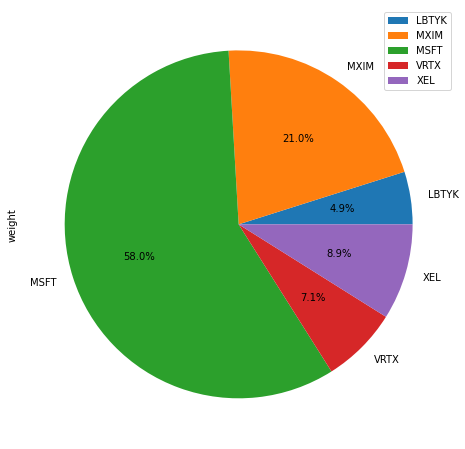

In [79]:
plot_1 = wt19.plot.pie(y='weight', autopct='%1.1f%%', figsize=(8, 8))
plot_1

# Use the same portforlio to calculate 2020 return

In [80]:
port_idx

[56, 59, 63, 94, 98]

In [81]:
diff19=np.sum(abs(wt19['weight']@rt19[:,port_idx].T-idx_rt19))
diff20=np.sum(abs(wt19['weight']@rt20[:,port_idx].T-idx_rt20))
print('The difference applying the same portfolio chosen from 2019 tickers to 2020 data is {} compared wtih {}!'.format(round(diff20,4),round(diff19,4)))

The difference applying the same portfolio chosen from 2019 tickers to 2020 data is 1.1124 compared wtih 0.7892!


# (3) Repeat with m =  10, 20, …, 90, 100

In [82]:
m=np.linspace(10,100,10)
stk_chosen=dict(zip(m,['']*len(m)))
wt_stk_chosen=dict(zip(m,['']*len(m)))

In [83]:

for m in np.linspace(10,100,10):
    
    n=cor19.shape[1]
    A=np.zeros((n**2+n+1,n**2+n))
    sense=np.array(['']*A.shape[0])
    b=np.zeros((A.shape[0])) 
    
    for i in range(n):
        
        A[i,n*i:n*(i+1)]=1
        sense[i]='='
        b[i]=1

    for i in range(n):
        for j in range(n):
            A[i * n + j + n, i * n + j]=1
            A[i * n + j + n, j + n**2]=-1
            sense[i * n + j + n]='<'
            b[i * n + j + n]=0
    
    for j in range(n):
        A[n**2 + n, n**2 + j ] = 1
        sense[n**2 + n] = '='
        b[n**2 + n] = m
    
    for j in range(n):                            #a
        A[n**2 + n, n**2 + j ] = 1
        sense[n**2 + n] = '='
        b[n**2 + n] = m
    
    obj=np.hstack((np.ndarray.flatten(cor19),np.array([0]*n)))

    var_type=['B']*(n**2+n)
    
    StkMod = gp.Model()
    StkMod_x = StkMod.addMVar(len(obj),vtype=var_type) # vtype can be: 'C' or 'I' or 'B'
    StkMod_con = StkMod.addMConstrs(A, StkMod_x, sense, b)
    StkMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)

    StkMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    StkMod.optimize()
    
    port_idx=[]
    for i in range(n**2,len(obj),1):
        if StkMod_x.X[i]==1:
            port_idx.append(i-n**2)
    
        stk_chosen[m]=port_idx

In [84]:
ticker_select=pd.DataFrame(stk_chosen.items(),columns=['m','tickers'])
len(ticker_select.iloc[8,:][1])

90

# Optimize weight matrix for different m

In [85]:
stk_wt_all_name=[]
stk_wt_all_idx=[]

for stk in stk_chosen.values():
    m=len(stk)
    t=rt19.shape[0]
    A=np.zeros((t * 2 + 1 , t + m)) 
    sense=np.array(['']*A.shape[0])
    b=np.zeros((A.shape[0])) 
    for i in range(t):
        for j in range(len(stk)):
            #A[:5] are the weight of chosen stocks
            A[i * 2, j] = rt19[i, stk[j]]
            A[i * 2 + 1, j] = rt19[i, stk[j]]
        # A[6:6+250] --> y are the difference between weighted gain and index gain 
        # w.x - qt - y <= 0
        A[i * 2, i + m] = -1
        sense[i * 2] = '<'
        b[i * 2] = idx_rt19[i]
        #w.x - qt + y >= 0
        A[i * 2 + 1, i + m] = 1
        sense[i * 2 + 1] = '>'
        b[i * 2 + 1] = idx_rt19[i]

    #Sum of weight = 1
    for i in range(m):
        A[t*2, i] = 1
        b[t*2] = 1
        sense[t*2] = '='

    # Objective to minimize

    obj = np.hstack((np.zeros((m)),np.array([1]*t)))

    # Variable type

    var_type=['C']*A.shape[1]
    
    # Optimize
    StkMod = gp.Model()
    StkMod_x = StkMod.addMVar(len(obj),vtype=var_type) # vtype can be: 'C' or 'I' or 'B'
    StkMod_con = StkMod.addMConstrs(A, StkMod_x, sense, b)
    StkMod.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)

    StkMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    StkMod.optimize()
    
    stk_wt_name=dict(zip([ticker[i] for i in stk], StkMod.X[:m]))
    stk_wt_idx=dict(zip([i for i in stk],StkMod.X[:m]))
    stk_wt_all_name.append(stk_wt_name)
    stk_wt_all_idx.append(stk_wt_idx)

In [86]:
rt19[np.array(list(stk_wt_all_idx[1].keys()))].shape

(20, 100)

In [87]:
stk_idx=[]
stk_tkr=[]
stk_wt=[]
for sel in stk_wt_all_idx:
    stk_idx.append([i for i in sel.keys()])
    stk_tkr.append([ticker[i] for i in sel.keys()])
    stk_wt.append([i for i in sel.values()])

In [88]:
port_selection=pd.DataFrame(columns=['selection index','selection ticker','weights'],
                       index=['m=10','m=20','m=30','m=40','m=50','m=60','m=70','m=80','m=90','m=100'])
port_selection.iloc[:,0]=stk_idx
port_selection.iloc[:,1]=stk_tkr
port_selection.iloc[:,2]=stk_wt
port_selection

,selection index,selection ticker,weights
m=10,"[0, 4, 40, 53, 56, 59, 63, 79, 94, 98]","[ATVI, ALGN, EXPE, KHC, LBTYK, MXIM, MSFT, ROS...","[0.0442000816251551, 0.024995874294039634, 0.0..."
m=20,"[0, 4, 5, 10, 15, 17, 24, 36, 40, 51, 53, 56, ...","[ATVI, ALGN, GOOGL, ANSS, ADP, BIIB, CHTR, DLT...","[0.01756825161913682, 0.015084885097907412, 0...."
m=30,"[0, 1, 5, 12, 15, 17, 19, 24, 28, 34, 35, 36, ...","[ATVI, ADBE, GOOGL, AMAT, ADP, BIIB, BKNG, CHT...","[0.03189196295507514, 0.03448203558994392, 0.1..."
m=40,"[0, 1, 4, 5, 8, 12, 15, 17, 19, 23, 25, 29, 30...","[ATVI, ADBE, ALGN, GOOGL, AMGN, AMAT, ADP, BII...","[0.025964514371002778, 0.02629467998457026, 0...."
m=50,"[0, 1, 3, 4, 5, 8, 12, 15, 17, 19, 22, 23, 24,...","[ATVI, ADBE, ALXN, ALGN, GOOGL, AMGN, AMAT, AD...","[0.017277786096989357, 0.026378953694862366, 0..."
m=60,"[1, 2, 3, 4, 5, 8, 12, 15, 16, 17, 18, 22, 23,...","[ADBE, AMD, ALXN, ALGN, GOOGL, AMGN, AMAT, ADP...","[0.05918076630768743, 0.011091742793502663, 0...."
m=70,"[2, 3, 4, 6, 8, 11, 12, 15, 16, 17, 18, 19, 21...","[AMD, ALXN, ALGN, GOOG, AMGN, AAPL, AMAT, ADP,...","[0.00806823832939714, 0.0026489995729639384, 0..."
m=80,"[0, 2, 3, 4, 5, 8, 11, 12, 14, 15, 16, 17, 18,...","[ATVI, AMD, ALXN, ALGN, GOOGL, AMGN, AAPL, AMA...","[0.00861135341944239, 0.006452940814983598, 0...."
m=90,"[0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14, 1...","[ATVI, ADBE, AMD, ALXN, ALGN, GOOG, AMZN, AMGN...","[0.0034407988123856155, 0.020014628603631013, ..."
m=100,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[ATVI, ADBE, AMD, ALXN, ALGN, GOOGL, GOOG, AMZ...","[0.004222720908253134, 0.01713793953924502, 0...."


# Compare performance of portfolios with different m

In [89]:
sum_19=[]
sum_20=[]
daily_diff19=0
daily_diff20=0
for i in range(10):
    daily_diff19=0
    daily_diff20=0
    daily_diff_mtx19=rt19[:,np.array(list(stk_wt_all_idx[i].keys()))]@np.array(list(stk_wt_all_idx[i].values()))
    daily_diff_mtx20=rt20[:,np.array(list(stk_wt_all_idx[i].keys()))]@np.array(list(stk_wt_all_idx[i].values()))
    for j in range(t):
        daily_diff19+=abs(daily_diff_mtx19[j]-idx_rt19[j])
        daily_diff20+=abs(daily_diff_mtx20[j]-idx_rt20[j])
    sum_19.append(daily_diff19)
    sum_20.append(daily_diff20)

In [90]:
port_comp=pd.DataFrame(columns=['difference for 2019','difference for 2020'],
                       index=['m=10','m=20','m=30','m=40','m=50','m=60','m=70','m=80','m=90','m=100'])
port_comp.iloc[:,0]=sum_19
port_comp.iloc[:,1]=list(sum_20)

In [91]:
port_comp

,difference for 2019,difference for 2020
m=10,0.701218,1.100511
m=20,0.466268,0.853782
m=30,0.407021,0.755453
m=40,0.368247,0.761539
m=50,0.334010,0.772208
m=60,0.349468,1.146336
m=70,0.171729,0.534894
m=80,0.147683,0.535013
m=90,0.053779,0.364608
m=100,0.044911,0.365480


<AxesSubplot:>

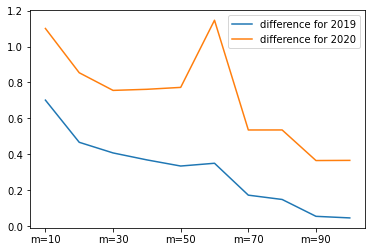

In [92]:
port_comp.plot(kind='line')

# key message here is the stock selection abased on 2019 data didn't perform as well in tracking index performance for 2020 data 

# (4) Another way to select stocks by minimizing difference

# m=5

In [93]:
# first 100 var are weights, second 200 are if a stock is selected (binary) for portfolio
# third batch 250 are the difference between daily return of portfolio and index funds


#obj[0X200+1X250]
obj=np.array([0]*n*2+[1]*t)       # 450 variables

#A.shape --> 602X450
A=np.zeros((n+t*2+2,2*n+t))       # 602 constraints

sense=['']*A.shape[0]  

b=np.zeros((A.shape[0]))

row = 0
# weight has to be 0 if the stk is not selected - 100 constraints
for i in range(n):

    A[row,i]=1
    A[row,i+n]=-1
    sense[row]='<'
    row+=1

# difference between weighted average of portfolio and index for each day (X-diff<index) 250 constrains
for i in range(t):

    A[row,:n]=rt19[i]
    A[row,2*n+i]=-1
    sense[row]='<'
    b[row]=idx_rt19[i]
    row+=1

# difference between weighted average of portfolio and index for each day (X+diff>index) 250 constrains
for i in range(t):

    A[row,:n]=rt19[i]
    A[row,2*n+i]=1
    sense[row]='>'
    b[row]=idx_rt19[i]
    row+=1

# all weights sum up to 1 ..........1 constraint
A[row,:n]=1
sense[n+2*t]='='
b[n+2*t]=1
row+=1

# total of m selected stocks  ...........1 constraint
A[row,n:2*n]=1
sense[row]='='
b[row]=5


v_type=['C']*100 + ['B'] * 100 + ['C'] * 250

StkMod = gp.Model()
StkMod_x = StkMod.addMVar(len(obj),vtype=v_type) # 'C' or 'I' or 'B'
StkMod_con = StkMod.addMConstrs(A, StkMod_x, sense, b)
StkMod.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)

StkMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
StkMod.Params.TimeLimit = timelimit
StkMod.optimize()

m5_wt=StkMod_x.X[:n]

In [94]:
m5_wt[np.where(m5_wt>0)]

array([2.50122598e-01, 1.13758071e-01, 1.91692206e-01, 1.26634814e-16,
       2.89869280e-01, 1.54557845e-01])

In [95]:
ticker[np.where(m5_wt>0)].values

array(['AMZN', 'ADI', 'AAPL', 'CERN', 'MSFT', 'MDLZ'], dtype=object)

In [96]:
m5_wt19_2=pd.DataFrame(m5_wt[np.where(m5_wt>0)],columns=['weight'],index=ticker[np.where(m5_wt>0)])

In [97]:
m5_wt19_2

,weight
AMZN,2.501226e-01
ADI,1.137581e-01
AAPL,1.916922e-01
CERN,1.266348e-16
MSFT,2.898693e-01
MDLZ,1.545578e-01


<AxesSubplot:ylabel='weight'>

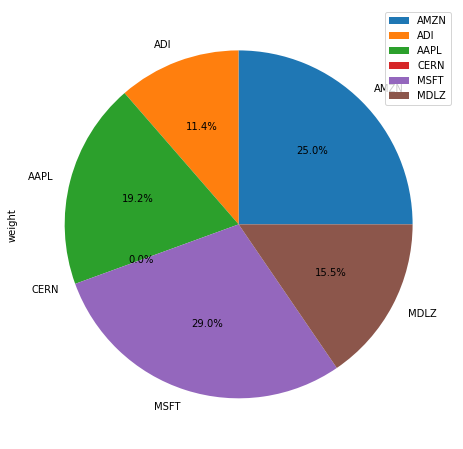

In [98]:
plot_2 = m5_wt19_2.plot.pie(y='weight', autopct='%1.1f%%', figsize=(8, 8))
plot_2

# For m = 10,20,30...100

In [99]:
#Period of return ~250
t=rt19.shape[0]
#of tickers ~100
n=rt19.shape[1]
#of tickers in portfolio
m_number=list(np.linspace(10,100,10))
#Big M=1
M=1


In [100]:
port_comp2=pd.DataFrame(columns=['difference for 2019','difference for 2020'],
                       index=['m=10','m=20','m=30','m=40','m=50','m=60','m=70','m=80','m=90','m=100'])

In [101]:
#For all Xi, Xi - Yi <= 0.

'''
diff=[]
weight=[]
for m in m_number:
            
            # first 100 var are weights, second 200 are if a stock is selected (binary) for portfolio
            # third batch 250 are the difference between daily return of portfolio and index funds
            
            #obj[0X200+1X250]
            obj=np.array([0]*n*2+[1]*t)       # 450 variables
            
            #A.shape --> 602X450
            A=np.zeros((n+t*2+2,2*n+t))       # 602 constraints
            
            sense=['']*A.shape[0]  
            
            b=np.zeros((A.shape[0]))

            row = 0
            # weight has to be 0 if the stk is not selected - 100 constraints
            for i in range(n):

                A[row,i]=1
                A[row,i+n]=-M
                sense[row]='<'
                row+=1
                
            # difference between weighted average of portfolio and index for each day (X-diff<index) 250 constrains
            for i in range(t):
                
                A[row,:n]=rt19[i]
                A[row,2*n+i]=-1
                sense[row]='<'
                b[row]=idx_rt19[i]
                row+=1

            # difference between weighted average of portfolio and index for each day (X+diff>index) 250 constrains
            for i in range(t):
                
                A[row,:n]=rt19[i]
                A[row,2*n+i]=1
                sense[row]='>'
                b[row]=idx_rt19[i]
                row+=1
                
            # all weights sum up to 1 ..........1 constraint
            A[row,:n]=1
            sense[n+2*t]='='
            b[n+2*t]=1
            row+=1
            
            # total of m selected stocks  ...........1 constraint
            A[row,n:2*n]=1
            sense[row]='='
            b[row]=m
            

            v_type=['C']*100 + ['B'] * 100 + ['C'] * 250

            StkMod = gp.Model()
            StkMod_x = StkMod.addMVar(len(obj),vtype=v_type) # 'C' or 'I' or 'B'
            StkMod_con = StkMod.addMConstrs(A, StkMod_x, sense, b)
            StkMod.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)

            StkMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
            StkMod.Params.TimeLimit = timelimit
            StkMod.optimize()
            
            
            diff.append(StkMod.objVal)
            weight.append(StkMod_x.X[:n])

diff19=pd.DataFrame(diff,columns=['difference in 2019'])
wt19=pd.DataFrame(weight)
diff19.to_csv('diff19.csv',index=False)
wt19.to_csv('wt19.csv',index=False)

port_comp2['difference for 2019']=diff
for i in range(len(weight)):
    port_comp2['difference for 2020'][i]=sum(abs(np.sum(weight[i]*rt20,axis=0)-idx_rt20[i]))
port_comp2

'''

"\ndiff=[]\nweight=[]\nfor m in m_number:\n            \n            # first 100 var are weights, second 200 are if a stock is selected (binary) for portfolio\n            # third batch 250 are the difference between daily return of portfolio and index funds\n            \n            #obj[0X200+1X250]\n            obj=np.array([0]*n*2+[1]*t)       # 450 variables\n            \n            #A.shape --> 602X450\n            A=np.zeros((n+t*2+2,2*n+t))       # 602 constraints\n            \n            sense=['']*A.shape[0]  \n            \n            b=np.zeros((A.shape[0]))\n\n            row = 0\n            # weight has to be 0 if the stk is not selected - 100 constraints\n            for i in range(n):\n\n                A[row,i]=1\n                A[row,i+n]=-M\n                sense[row]='<'\n                row+=1\n                \n            # difference between weighted average of portfolio and index for each day (X-diff<index) 250 constrains\n            for i in range(t):

In [102]:
port_selection2=port_selection
wt19_2=np.array(np.array(pd.read_csv('wt19.csv')))
for i in range(wt19_2.shape[0]):
    port_selection2['selection index'][i]=np.where(wt19_2[i]>0)
    port_selection2['selection ticker'][i]=ticker[np.where(wt19_2[i]>0)].values
    port_selection2['weights'][i]=wt19_2[i][np.where(wt19_2[i]>0)]
port_selection2

,selection index,selection ticker,weights
m=10,"([5, 7, 11, 27, 41, 44, 48, 63, 93, 99],)","[GOOGL, AMZN, AAPL, CSCO, FB, GILD, INTC, MSFT...","[0.1147028884648668, 0.1275886567495478, 0.140..."
m=20,"([1, 6, 7, 8, 11, 27, 30, 41, 44, 48, 62, 63, ...","[ADBE, GOOG, AMZN, AMGN, AAPL, CSCO, CMCSA, FB...","[0.0354315281422861, 0.091502305287932, 0.0998..."
m=30,"([1, 5, 7, 8, 11, 15, 16, 17, 19, 20, 21, 24, ...","[ADBE, GOOGL, AMZN, AMGN, AAPL, ADP, BIDU, BII...","[0.0243128563031083, 0.0898908387923361, 0.095..."
m=40,"([1, 5, 7, 8, 11, 15, 17, 19, 20, 27, 28, 30, ...","[ADBE, GOOGL, AMZN, AMGN, AAPL, ADP, BIIB, BKN...","[0.0256881596765564, 0.0836437012254965, 0.097..."
m=50,"([0, 1, 2, 5, 7, 8, 11, 14, 15, 16, 17, 18, 19...","[ATVI, ADBE, AMD, GOOGL, AMZN, AMGN, AAPL, ADS...","[0.0055295297871961, 0.0195444196032516, 0.005..."
m=60,"([1, 2, 5, 7, 8, 11, 14, 15, 16, 17, 18, 19, 2...","[ADBE, AMD, GOOGL, AMZN, AMGN, AAPL, ADSK, ADP...","[0.0178951534248061, 0.0037866258989731, 0.086..."
m=70,"([0, 1, 2, 5, 7, 8, 11, 12, 14, 15, 16, 17, 18...","[ATVI, ADBE, AMD, GOOGL, AMZN, AMGN, AAPL, AMA...","[0.0034937937360363, 0.0182694353229364, 0.003..."
m=80,"([0, 1, 2, 3, 5, 6, 7, 8, 11, 12, 13, 14, 15, ...","[ATVI, ADBE, AMD, ALXN, GOOGL, GOOG, AMZN, AMG...","[0.0031192740211572, 0.0178445065401232, 0.003..."
m=90,"([0, 1, 2, 3, 5, 6, 7, 8, 11, 12, 13, 14, 15, ...","[ATVI, ADBE, AMD, ALXN, GOOGL, GOOG, AMZN, AMG...","[0.0042232895931933, 0.0171400492740289, 0.004..."
m=100,"([0, 1, 2, 3, 5, 6, 7, 8, 11, 12, 13, 14, 15, ...","[ATVI, ADBE, AMD, ALXN, GOOGL, GOOG, AMZN, AMG...","[0.0042232895931936, 0.0171400492740285, 0.004..."


In [103]:

for i in range(10):
    port_comp2['difference for 2019'][i]=np.sum(abs(rt19[:,np.where(wt19_2[i]>0)[0]]@wt19_2[i][np.where(wt19_2[i]>0)]-idx_rt19))
    port_comp2['difference for 2020'][i]=np.sum(abs(rt20[:,np.where(wt19_2[i]>0)[0]]@wt19_2[i][np.where(wt19_2[i]>0)]-idx_rt20))

port_comp2

,difference for 2019,difference for 2020
m=10,0.30357,0.691485
m=20,0.166274,0.57254
m=30,0.110948,0.508069
m=40,0.078818,0.432141
m=50,0.062072,0.375637
m=60,0.051871,0.381008
m=70,0.047567,0.358158
m=80,0.045227,0.370629
m=90,0.044911,0.368682
m=100,0.044911,0.368682


<AxesSubplot:>

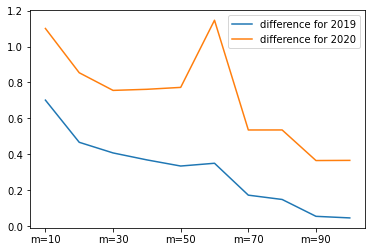

In [104]:
port_comp.plot(kind='line')

<AxesSubplot:>

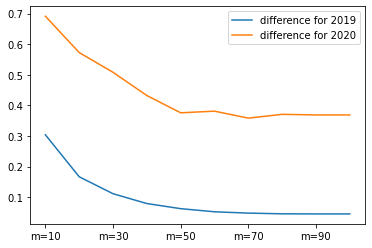

In [105]:
port_comp2.plot(kind='line')

# m = 50

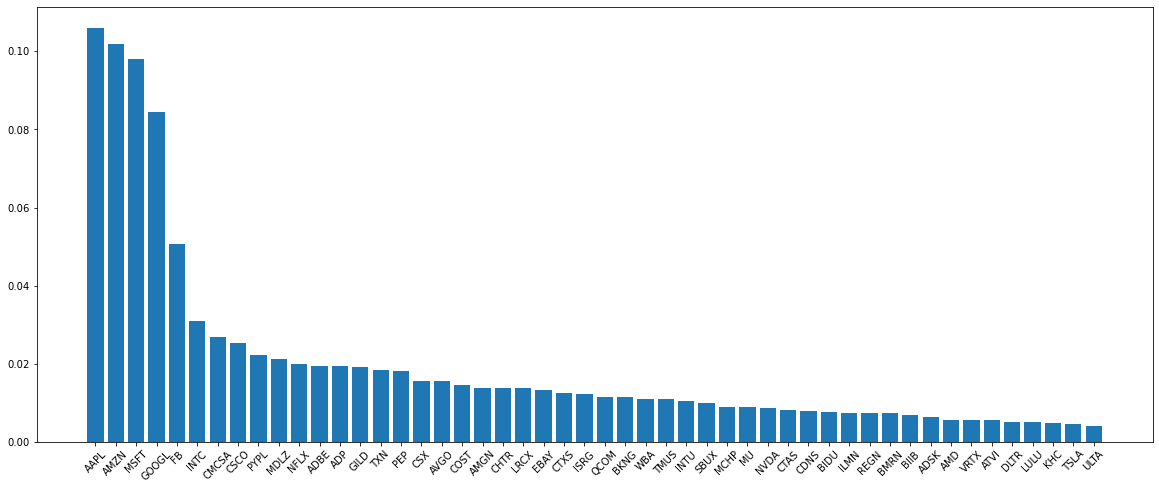

In [106]:
#Stock selection at m=50
df = pd.read_csv('wt19.csv')

a=stk_19.drop(columns = ['NDX'])
df.columns = list(a.columns.values)

df_T = df.T

df_T.columns = [10,20,30,40,50,60,70,80,90,100]

df_t_50 = df_T[df_T[50] != 0][[50]].sort_values(50, ascending = False)

import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20, 8))
plt.bar(df_t_50.index, df_t_50[50])
plt.xticks(rotation=45)
plt.show()